# Logistic Regression

Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist. In regression analysis, logistic regression (or logit regression) is estimating the parameters of a logistic model (a form of binary regression).

![logistic_reg1](./images/logistic_reg1.png)

In [4]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

%matplotlib inline 

In [5]:
def linear_model_format_X(X):
    if len(X.shape) == 1:
        X = X.copy().reshape(-1,1)
    
    return np.hstack(tup= ( np.ones(shape=(X.shape[0],1)) , X ) )

## Cost Function

### The cross-entropy loss function
We need a loss function that expresses, for an observationx, how close the classifier output 

        ( ˆy = σ(w·x+b) ) 
        
is to the correct output (y, which is 0 or 1). We’ll call this:

        L(ˆy,y) =How much  ˆy differs from the true y 
        
We do this via a loss function that prefers the correct class labels of the train-ing examples to bemore likely.  This is called conditional maximum likelihood estimation:  we choose the parametersw,b thatmaximize the log probability ofthe true y labels in the training datagiven the observations x.  The resulting loss function is the negative log likelihood loss, generally called the cross-entropy loss.

![logistic_reg_2](./images/logistic_reg2.png)
![logistic_reg3](./images/logistic_reg3.png)

In [6]:
def calculate_entropy_cost(y_pred,y):
    
    part_1 = y * np.log(y_pred)
    
    part_2 = (1 - y) * np.log(1 - y_pred) 
    
    cost = ( -1 / y_pred.shape[0] ) * np.sum(part_1 + part_2)   
    return cost

## Sigmoid Function

![logistic_reg11](./images/logistic_reg11.png)

In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

## Gradient Descent Algorithm

![logistic_reg4](./images/logistic_reg4.png)

![logistic_reg_9](./images/logistic_reg9.png)

### Math Calculation for Gradient Descent
![logistic_reg5](./images/logistic_reg5.png)

![logistic_reg6](./images/logistic_reg6.png)

![logistic_reg7](./images/logistic_reg7.png)

In [15]:
class LogisticRegression:
    def __init__(self,alpha = 0.01 ,iterations = 10000):
        self.alpha = alpha
        self.iterations = iterations
        self._theta = None
        self._X = None
        self._y = None
        self._theta_history = None
        self._cost_history = None
    
    def _format_X_for_theta_0(self,X_i):
        
        X_i = X_i.copy()
        if len(X_i.shape) == 1:
            X_i = X_i.reshape(-1,1)
            
        if False in (X_i[...,0] == 1):        
            return np.hstack(tup=(np.ones(shape=(X_i.shape[0],1)) , X_i))
        else:
            return X_i
    
    @property
    def X(self):
        return self._X
    
    @property
    def y(self):
        return self._y
    
    @property
    def theta(self):
        return self._theta
    
    @property
    def theta_history(self):
        return self._theta_history
    
    @property
    def cost_history(self):
        return self._cost_history
    
    def predict(self,X):
        format_X = self._format_X_for_theta_0(X)
        
        if format_X.shape[1] == self._theta.shape[0]:
            y_pred = sigmoid(format_X @ self._theta) # (m,1) = (m,n) * (n,1)
            return y_pred
        elif format_X.shape[1] == self._theta.shape[1]:
            y_pred = sigmoid(format_X @ self._theta.T) # (m,1) = (m,n) * (n,1)
            return y_pred
        else:
            raise ValueError("Shape is not proper.")
            
    
    def train(self, X, y, verbose=True, method="BGD", theta_precision = 0.001, batch_size=30, regularization=False, penalty=1.0):
        
        self._X = self._format_X_for_theta_0(X)
        self._y = y

        # number of features+1 because of theta_0
        self._n = self._X.shape[1]
        self._m = self._y.shape[0]

        self._theta_history = []
        self._cost_history = []

        if method == "BGD":
            self._theta = np.random.rand(1,self._n) * theta_precision
            if verbose: print("random initial θ value :",self._theta)
            
            for iteration in range(self.iterations):
                # calculate y_pred 
                y_pred = self.predict(self._X)
                
                # new θ to replace old θ
                new_theta = None

                # simultaneous operation 
                
                if regularization:
                    gradient = np.mean( ( y_pred - self._y ) * self._X, axis = 0 )
                    new_theta_0 = self._theta[:,[0]] - (self.alpha *  gradient[0])
                    new_theta_rest = self._theta[:,range(1,self._n)] * (1 - (penalty/self._m) ) - (self.alpha *  gradient[1:])
                    new_theta = np.hstack((new_theta_0,new_theta_rest))
                    
                else:
                    gradient = np.mean( ( y_pred - self._y ) * self._X, axis = 0 )
                    new_theta = self._theta - (self.alpha *  gradient)

                if np.isnan(np.sum(new_theta)) or np.isinf(np.sum(new_theta)):
                    print("breaking. found inf or nan.")
                    break
                # override with new θ 
                self._theta = new_theta

                # calculate cost to put in history
                cost = calculate_entropy_cost(y_pred = self.predict(X=self._X), y = self._y)
                self._cost_history.append(cost)

                # calcualted theta in history
                self._theta_history.append(self._theta[0])
                
        elif method == "SGD": # stochastic gradient descent
            self._theta = np.random.rand(1,self._n) * theta_precision
            if verbose: print("random initial θ value :",self._theta)
            
            for iteration in range(self.iterations):
                
                # creating indices for batches
                indices = np.random.randint(0,self._m,size=batch_size)
                
                # creating batch for this iteration
                X_batch = np.take(self._X,indices,axis=0)
                y_batch = np.take(self._y,indices,axis=0)
                
                # calculate y_pred 
                y_pred = self.predict(X_batch)
                # new θ to replace old θ
                new_theta = None
                
                # simultaneous operation 
                if regularization:
                    gradient = np.mean( ( y_pred - y_batch ) * X_batch, axis = 0 )
                    new_theta_0 = self._theta[:,[0]] - (self.alpha *  gradient[0])
                    new_theta_rest = self._theta[:,range(1,self._n)] * (1 - (penalty/self._m) ) - (self.alpha *  gradient[1:])
                    new_theta = np.hstack((new_theta_0,new_theta_rest))
                    
                    
                else:
                    gradient = np.mean( ( y_pred - y_batch ) * X_batch, axis = 0 )
                    new_theta = self._theta - (self.alpha *  gradient)

                if np.isnan(np.sum(new_theta)) or np.isinf(np.sum(new_theta)):
                    print("breaking. found inf or nan.")
                    break
                # override with new θ 
                self._theta = new_theta

                # calculate cost to put in history
                cost = calculate_entropy_cost(y_pred = self.predict(X=X_batch), y = y_batch)
                self._cost_history.append(cost)

                # calcualted theta in history
                self._theta_history.append(self._theta[0])
            
        else:
            print("No Method Defined.")
      
    

In [16]:
from sklearn.datasets import load_breast_cancer

dataset = load_breast_cancer()

df = pd.DataFrame(data=dataset.data,columns=dataset.feature_names)
df["target"] = dataset.target
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [17]:
X = df[dataset.feature_names].values
y = df["target"].values.reshape(-1,1)

X.shape, y.shape

((569, 30), (569, 1))

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score

scaler = StandardScaler()


X_i = df[dataset.feature_names].values
y = df["target"].values.reshape(-1,1)


X_scaled = scaler.fit_transform(X_i)

## Logitsic Regression without Regression

### Batch Gradient Descent

random initial θ value : [[3.43820676e-04 2.44234637e-04 8.47725902e-04 9.89584263e-04
  8.07625081e-05 6.63540762e-04 6.07785027e-04 8.64214692e-04
  2.32109312e-04 6.14707278e-04 5.80991051e-04 8.49034246e-04
  5.46092066e-04 9.69119288e-04 7.46816816e-04 3.33439672e-04
  7.35565522e-04 9.38340924e-04 2.82191206e-04 3.67408286e-04
  3.58850540e-05 4.87965118e-04 9.74260763e-04 9.14496325e-04
  6.73616246e-04 3.37368327e-04 4.17933103e-04 6.93937054e-04
  8.67834883e-04 4.08157926e-04 6.70602416e-04]]
Fit theta : [[ 0.4315998  -0.48964772 -0.50222963 -0.47967426 -0.49500558 -0.1875647
  -0.07384953 -0.40875014 -0.5264858  -0.10616663  0.26988978 -0.52549664
   0.00154857 -0.42177722 -0.45803567 -0.04403054  0.24807097  0.10826863
  -0.07833925  0.12907899  0.30277893 -0.62812932 -0.64870895 -0.59072385
  -0.59718205 -0.48696368 -0.21381106 -0.42197195 -0.57304068 -0.43079668
  -0.13505408]]

Confusion Matrix : 
[[205   7]
 [  2 355]]
Accuracy Score   : 
0.984182776801406



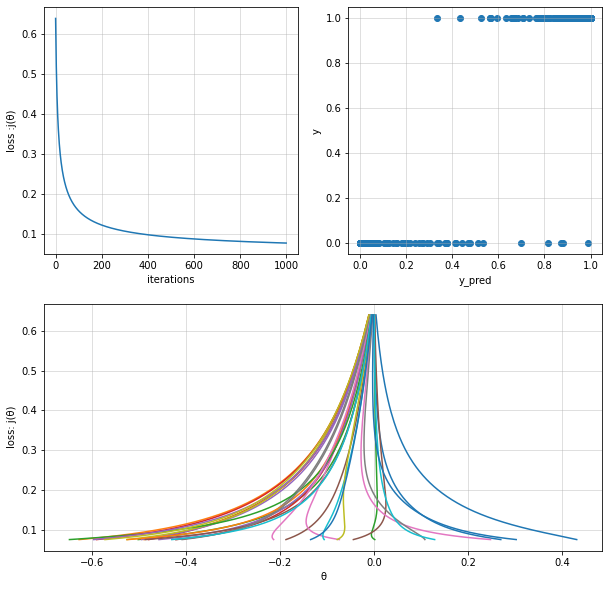

In [19]:
logisitc_reg_model1 = LogisticRegression(alpha=0.03,iterations=1000)
logisitc_reg_model1.train(X=X_scaled, y=y, method="BGD")

y = logisitc_reg_model1.y
y_pred = logisitc_reg_model1.predict(X_scaled)
theta = logisitc_reg_model1.theta
theta_history = logisitc_reg_model1.theta_history
cost_history = logisitc_reg_model1.cost_history


print("Fit theta :",theta)

print(f"""
Confusion Matrix : 
{confusion_matrix(y,y_pred>0.5)}
Accuracy Score   : 
{accuracy_score(y,y_pred>0.5)}
""")


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2,2,1)
ax.set(
    xlabel="iterations",
    ylabel="loss :j(θ)"
)
ax.plot(cost_history)
ax.grid(alpha=0.5)

ax = fig.add_subplot(2,2,2)
ax.set(
    xlabel="y_pred",
    ylabel="y"
)
ax.scatter(y_pred,y)
ax.grid(alpha=0.5)

ax = fig.add_subplot(2,2,(3,4))
ax.set(
    ylabel="loss: j(θ)",
    xlabel="θ"
)
ax.plot(theta_history,cost_history)
ax.grid(alpha=0.5)
plt.show()

### Stochastic Gradient Descent

random initial θ value : [[4.41479798e-04 4.72812804e-04 2.24844495e-04 2.52188226e-04
  3.74074942e-04 5.70537261e-04 7.85943901e-04 4.72820141e-04
  4.55924113e-04 4.16492283e-04 3.82408490e-04 9.44135705e-04
  1.29332729e-04 5.64789391e-04 3.16377631e-04 7.38196916e-04
  7.43560933e-04 8.61175965e-04 8.70590693e-04 5.06208886e-04
  7.83172394e-05 1.90136784e-04 6.88824551e-04 7.85230465e-04
  7.80573678e-04 6.60524224e-04 2.88242723e-05 6.88352550e-04
  9.24426652e-04 7.85744968e-05 5.37121726e-04]]
Fit theta : [[ 0.42771334 -0.48810798 -0.50152412 -0.47890263 -0.49333594 -0.1853348
  -0.07251305 -0.4059144  -0.52516415 -0.1100023   0.26840855 -0.53028862
   0.0035719  -0.42656492 -0.45947704 -0.0388459   0.25399678  0.1078797
  -0.08428098  0.12971902  0.30779179 -0.62691221 -0.64391814 -0.58933645
  -0.59502922 -0.48699982 -0.21652376 -0.42142102 -0.57622444 -0.43416154
  -0.13581235]]

Confusion Matrix : 
[[205   7]
 [  2 355]]
Accuracy Score   : 
0.984182776801406



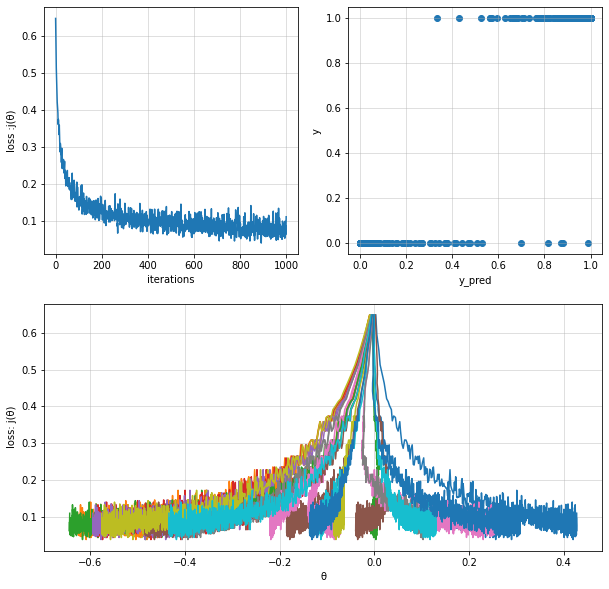

In [20]:
logisitc_reg_model2 = LogisticRegression(alpha=0.03,iterations=1000)
logisitc_reg_model2.train(X=X_scaled, y=y, method="SGD",batch_size=200)

y = logisitc_reg_model2.y
y_pred = logisitc_reg_model2.predict(X_scaled)
theta = logisitc_reg_model2.theta
theta_history = logisitc_reg_model2.theta_history
cost_history = logisitc_reg_model2.cost_history


print("Fit theta :",theta)

print(f"""
Confusion Matrix : 
{confusion_matrix(y,y_pred>0.5)}
Accuracy Score   : 
{accuracy_score(y,y_pred>0.5)}
""")


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2,2,1)
ax.set(
    xlabel="iterations",
    ylabel="loss :j(θ)"
)
ax.plot(cost_history)
ax.grid(alpha=0.5)

ax = fig.add_subplot(2,2,2)
ax.set(
    xlabel="y_pred",
    ylabel="y"
)
ax.scatter(y_pred,y)
ax.grid(alpha=0.5)

ax = fig.add_subplot(2,2,(3,4))
ax.set(
    ylabel="loss: j(θ)",
    xlabel="θ"
)
ax.plot(theta_history,cost_history)
ax.grid(alpha=0.5)
plt.show()

## Logistic Regression with Regularization

![logistic_reg8](./images/logistic_reg8.png)

- Addressing Overfitting
    - Reduce features
        - manually select
        - model selection algorithm
    - Regularization
        - Keep all the features but reduce magnitude/values of parameter theta
        - Works well when we have a lot of features and each contributes a bit to predicting y

![logistic_reg10](./images/logistic_reg10.png)

### Stochastic Gradient Descent

random initial θ value : [[5.19825530e-04 2.56134765e-04 4.91584163e-04 7.50997107e-04
  8.25121219e-04 4.33021824e-04 4.61548622e-05 4.46434801e-04
  6.21568202e-04 5.25479258e-04 8.47013069e-04 6.65760723e-04
  8.02776558e-04 9.45237426e-04 2.90484980e-04 3.18601539e-04
  2.91675714e-04 4.81967873e-04 9.04864690e-04 8.52410849e-05
  7.15320373e-04 4.81469781e-04 4.59864590e-04 5.55660238e-04
  8.94333121e-04 2.45143657e-04 4.17173704e-05 9.46852887e-04
  3.43192288e-04 7.63738254e-07 3.38543039e-04]]
Fit theta : [[ 0.51623671 -0.30850679 -0.29438282 -0.30370206 -0.29970758 -0.11393905
  -0.08213339 -0.2535341  -0.32390646 -0.07544541  0.15096525 -0.28867912
   0.00931243 -0.23586193 -0.24895518 -0.01071647  0.10312401  0.04529798
  -0.07163214  0.07115136  0.1479496  -0.37593874 -0.37311871 -0.35729218
  -0.34501709 -0.27574379 -0.16238925 -0.26571529 -0.35932896 -0.2603452
  -0.10132424]]

Confusion Matrix : 
[[199  13]
 [  1 356]]
Accuracy Score   : 
0.9753954305799648



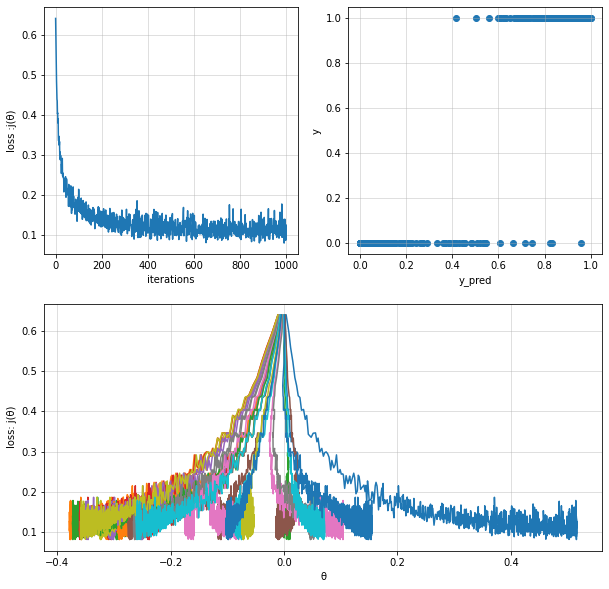

In [23]:
logisitc_reg_model3 = LogisticRegression(alpha=0.03,iterations=1000)
logisitc_reg_model3.train(X=X_scaled, y=y, method="SGD",batch_size=200,regularization=True,penalty=1.0)

y = logisitc_reg_model3.y
y_pred = logisitc_reg_model3.predict(X_scaled)
theta = logisitc_reg_model3.theta
theta_history = logisitc_reg_model3.theta_history
cost_history = logisitc_reg_model3.cost_history


print("Fit theta :",theta)

print(f"""
Confusion Matrix : 
{confusion_matrix(y,y_pred>0.5)}
Accuracy Score   : 
{accuracy_score(y,y_pred>0.5)}
""")


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2,2,1)
ax.set(
    xlabel="iterations",
    ylabel="loss :j(θ)"
)
ax.plot(cost_history)
ax.grid(alpha=0.5)

ax = fig.add_subplot(2,2,2)
ax.set(
    xlabel="y_pred",
    ylabel="y"
)
ax.scatter(y_pred,y)
ax.grid(alpha=0.5)

ax = fig.add_subplot(2,2,(3,4))
ax.set(
    ylabel="loss: j(θ)",
    xlabel="θ"
)
ax.plot(theta_history,cost_history)
ax.grid(alpha=0.5)
plt.show()

### Batch Gradient Descent

random initial θ value : [[6.46660261e-04 3.88439846e-04 8.70254981e-05 6.49385296e-04
  2.94954815e-04 6.16950798e-04 7.81887247e-04 6.33693784e-04
  1.25202741e-04 6.01520289e-04 7.04939567e-04 5.81517466e-04
  4.60401273e-04 6.31197046e-04 3.69087881e-04 1.08115976e-04
  1.76891441e-04 4.72463299e-04 2.16930510e-04 4.10883291e-04
  6.08284943e-04 1.81311793e-04 2.50574954e-04 4.56421679e-04
  3.39055787e-04 9.51261146e-04 9.30382572e-04 4.20613075e-04
  9.10470954e-04 2.98184766e-04 3.34037216e-06]]
Fit theta : [[ 0.56113368 -0.25573136 -0.22787571 -0.25259736 -0.24257025 -0.10101348
  -0.09227762 -0.20080848 -0.26143928 -0.07107671  0.11375412 -0.21359598
   0.01085161 -0.17923597 -0.1855201   0.00251606  0.05404883  0.0318219
  -0.06782272  0.05134941  0.10657932 -0.29963945 -0.28257897 -0.28746323
  -0.26934137 -0.21298829 -0.14924521 -0.21219736 -0.29231033 -0.20462169
  -0.08327179]]

Confusion Matrix : 
[[196  16]
 [  1 356]]
Accuracy Score   : 
0.9701230228471002



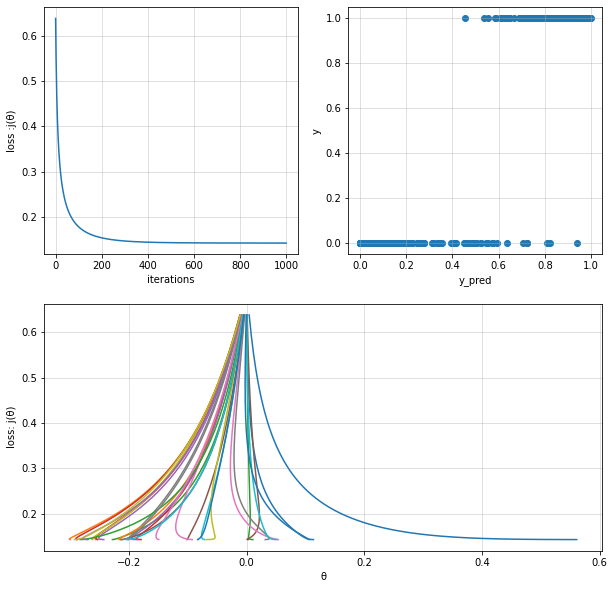

In [24]:
logisitc_reg_model4 = LogisticRegression(alpha=0.03,iterations=1000)
logisitc_reg_model4.train(X=X_scaled, y=y, method="BGD",regularization=True,penalty=2.0)

y = logisitc_reg_model4.y
y_pred = logisitc_reg_model4.predict(X_scaled)
theta = logisitc_reg_model4.theta
theta_history = logisitc_reg_model4.theta_history
cost_history = logisitc_reg_model4.cost_history


print("Fit theta :",theta)

print(f"""
Confusion Matrix : 
{confusion_matrix(y,y_pred>0.5)}
Accuracy Score   : 
{accuracy_score(y,y_pred>0.5)}
""")


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2,2,1)
ax.set(
    xlabel="iterations",
    ylabel="loss :j(θ)"
)
ax.plot(cost_history)
ax.grid(alpha=0.5)

ax = fig.add_subplot(2,2,2)
ax.set(
    xlabel="y_pred",
    ylabel="y"
)
ax.scatter(y_pred,y)
ax.grid(alpha=0.5)

ax = fig.add_subplot(2,2,(3,4))
ax.set(
    ylabel="loss: j(θ)",
    xlabel="θ"
)
ax.plot(theta_history,cost_history)
ax.grid(alpha=0.5)
plt.show()